In [15]:
#from transformers import pipeline,  AutoProcessor, AutoModelForSeq2SeqLM, \
#    BlipProcessor, BlipForConditionalGeneration, Blip2ForConditionalGeneration 
import torch
from PIL import Image
import json
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import random
#https://github.com/salesforce/LAVIS
from lavis.models import load_model_and_preprocess
from utils.coco_utils.annotate_images import annotate_img
device = "cuda" if torch.cuda.is_available() else "cpu"



In [ ]:
# https://medium.com/@enrico.randellini/image-and-text-features-extraction-with-blip-and-blip-2-how-to-build-a-multimodal-search-engine-a4ceabf51fbe
# https://medium.com/@ichigo.v.gen12/blip-2-paper-review-and-explore-blip-2s-embedding-space-180574623712
# chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2303.06594
model, vis_processors, _ = load_model_and_preprocess(name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device)

In [29]:
dataset_dir = 'E:/datasets'
dataset_name = 'DOTA_dataset_512'
coco_dir = f'{dataset_dir}/{dataset_name}'
coco_file = f'{coco_dir}/YOLO_coco_results_annots.json'

with open(coco_file, 'r') as f:
    coco_json = json.load(f)

image_id_to_annots = defaultdict(list)
for annot in coco_json['annotations']:
#    if annot['category_id'] in cats_to_use:
        image_id_to_annots[annot['image_id']].append(annot)

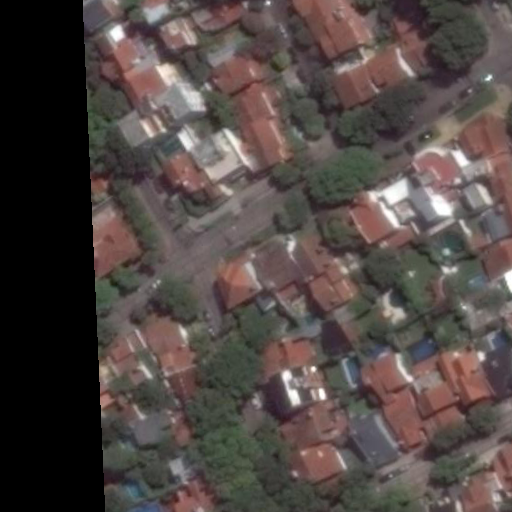

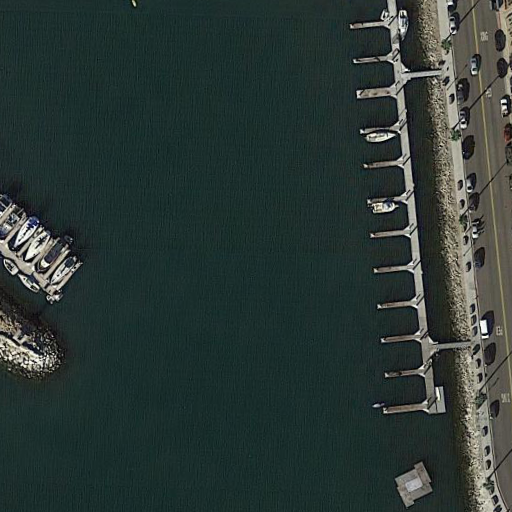

In [46]:
img_dict = random.choice(coco_json['images'])
image_path = img_dict['path']
img = Image.open(image_path).convert('RGB')
image_annotations = image_id_to_annots.get(img_dict['id'], [])
img_dict2 = random.choice(coco_json['images'])
image_path2 = img_dict2['path']
img2 = Image.open(image_path2).convert('RGB')
display(img)
display(img2)

c:\Users\neals\anaconda3\envs\practicum\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


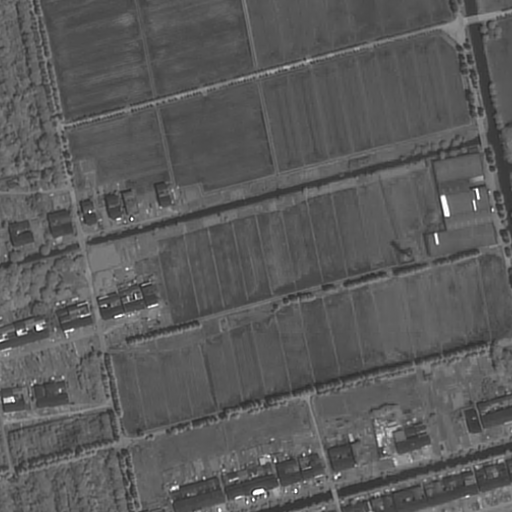

In [39]:


image = vis_processors["eval"](img).unsqueeze(0).to(device)
display(img)

In [47]:
image = vis_processors["eval"](img).unsqueeze(0).to(device)
image2 = vis_processors["eval"](img2).unsqueeze(0).to(device)
image3 = torch.cat([image,image2],dim=0)
model.generate({"image": image3})

['an aerial view of houses in a residential area',
 'an aerial view of a marina with boats in the water']

In [12]:
model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3)

['the jet at the airport on the ground',
 'the aeroplane is parked in the middle of the runway',
 'a large jet airplane is parked on the tarmac at an airport']

In [13]:
model.generate({"image": image, "prompt": "Question: which city is this? Answer:"})

["it's not a city, it's an airport"]

In [54]:
prompts = ["","describe this image in detail.", "how many planes are there?", "Question: what object is in this image? Answer:",
           "Question: what objects are in this image? Answer:", "Question: is there a car in this image? Answer:",
           "Question: what shapes are in the image? Answer:", "Question: How many boats are there? Answer:",
           "Question: what is this? Answer:", "Question: What is in the image and how many boats are there? Answer:",
           "Question: is there a car in this image, If you are not sure about the answer, say you don't know honestly? Answer:",
           "Question: Where is the boat? Answer:","Question: Describe the image in detail in as many words as possible. Answer:"]

prompts = ["", "An image of","Question: is there a car in this image, If you are not sure about the answer, say you don't know honestly? Answer:",
               "Question: is anything moving? Answer:", "Question: what shapes are in the image? Answer:"]
for prompt in prompts:
    print(prompt)
    #print(model.generate({"image": image, "prompt": prompt}, use_nucleus_sampling=True, num_captions=3))
    print(model.generate({"image": image, "prompt": prompt}, use_nucleus_sampling=False, num_captions=1))
    #print(model.generate({"image": image, "prompt": prompt}, use_nucleus_sampling=True, temperature=0.7, repetition_penalty=1.3, min_length=16, max_length=64))



['an aerial view of a field with red markers']
An image of
['an aerial view of a field with red markers']
Question: is there a car in this image, If you are not sure about the answer, say you don't know honestly? Answer:
['no']
Question: is anything moving? Answer:
['no']
Question: what shapes are in the image? Answer:
['']


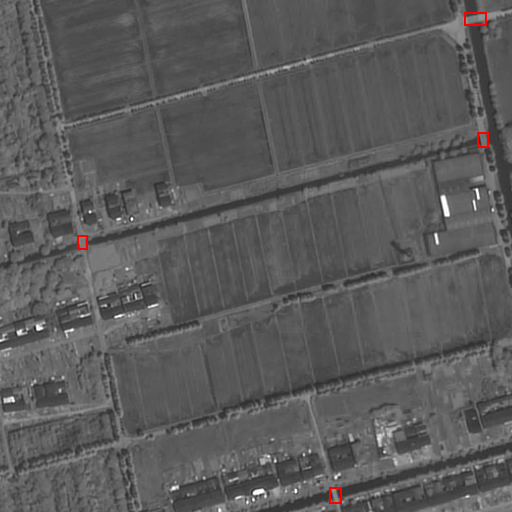

In [40]:
category_ids = [cat['id'] for cat in coco_json['categories']]
bboxes = [annot['bbox'] for annot in image_annotations]
annot_img = annotate_img(img, bboxes,category_ids, show_labels=False)
display(annot_img)

In [50]:
for cat in coco_json['categories']:
    print(f"{cat['id']}:{cat['name']}")

1:small-vehicle
2:large-vehicle
3:ship
4:harbor
5:baseball-diamond
6:soccer-ball-field
7:ground-track-field
8:swimming-pool
9:roundabout
10:tennis-court
11:basketball-court
12:plane
13:helicopter
14:bridge
15:storage-tank
16:container-crane


In [56]:
#[1,2,3,4,12,15]
objects_of_interest = ['car','truck','ship','plane','storage-tank',"swimming-pool","harbor"]
object_count_prompts = [f"Question: How many {obj}s are there? Answer:" for obj in objects_of_interest]
object_classification_prompts = [f"Question: Is there a {obj}? Answer:" for obj in objects_of_interest]
object_classification_ann_prompts = [f"Question: Is there a {obj} in the red box? Answer:" for obj in objects_of_interest]

image = vis_processors["eval"](annot_img).unsqueeze(0).to(device)
prompts =   object_classification_prompts
for prompt in prompts:
    print(prompt)
    print(model.generate({"image": image, "prompt": prompt}, use_nucleus_sampling=False)[0])

Question: Is there a car? Answer:
Yes
Question: Is there a truck? Answer:
yes
Question: Is there a ship? Answer:
No
Question: Is there a plane? Answer:
No
Question: Is there a storage-tank? Answer:
No
Question: Is there a swimming-pool? Answer:
No
Question: Is there a harbor? Answer:
No


In [41]:
prompts = ["","Question: Describe in great detail the objects in the image? Answer:",
            "how many planes are there?", "Question: what object is in this image? Answer:",
           "Question: How many planes are in red boxes? Answer:",
           "Question: What objects are in red boxes? Answer:",
           "Question: list the objects in red boxes? Answer:",
           "Question: What is in the red box? Answer:"]

image = vis_processors["eval"](annot_img).unsqueeze(0).to(device)
for prompt in prompts:
    print(prompt)
    #print(model.generate({"image": image, "prompt": prompt}, use_nucleus_sampling=True, num_captions=3))
    #print(model.generate({"image": image, "prompt": prompt}, use_nucleus_sampling=False, num_captions=1))
    #print(model.generate({"image": image, "prompt": prompt}, use_nucleus_sampling=True, temperature=0.7, repetition_penalty=1.3))#, min_length=16, max_length=64))
    print(model.generate({"image": image, "prompt": prompt}, use_nucleus_sampling=False, repetition_penalty=1.3))#,min_length=10))


['an aerial view of a field with red markers']
Question: Describe in great detail the objects in the image? Answer:
['']
how many planes are there?
['']
Question: what object is in this image? Answer:
['']
Question: How many planes are in red boxes? Answer:
['1']
Question: What is in red boxes? Answer:
['']
Question: list the objects in red boxes? Answer:
['']
Question: What is in the red box? Answer:
['a military installation']


In [14]:
'''
from transformers import AutoTokenizer, Blip2Model
model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b")
tokenizer = AutoTokenizer.from_pretrained("Salesforce/blip2-opt-2.7b")
inputs = tokenizer(["a photo of a cat"], padding=True, return_tensors="pt")
text_features = model.get_text_features(**inputs)
print(text_features)
'''

'\nfrom transformers import AutoTokenizer, Blip2Model\nmodel = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b")\ntokenizer = AutoTokenizer.from_pretrained("Salesforce/blip2-opt-2.7b")\ninputs = tokenizer(["a photo of a cat"], padding=True, return_tensors="pt")\ntext_features = model.get_text_features(**inputs)\nprint(text_features)\n'